In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Scaling

In [2]:
# Define your scaling function
def custom_scaling(input_values):
    input_values_scaled = np.zeros_like(input_values, dtype=float)  # Initialize scaled data array
    input_values_scaled[:, 0] = (input_values[:, 0] - L_min) / (L_max - L_min)  # Scale L
    input_values_scaled[:, 1] = (input_values[:, 1] - C_min) / (C_max - C_min)  # Scale C
    input_values_scaled[:, 2] = (input_values[:, 2] - fsw_min) / (fsw_max - fsw_min)  # Scale fsw
    input_values_scaled[:, 3] = (input_values[:, 3] - t_dt_min) / (t_dt_max - t_dt_min) # Scale t_dt
    return input_values_scaled

# Define your scaling function
def custom_scaling_1(input_values):
    input_values_scaled = np.zeros_like(input_values, dtype=float)  # Initialize scaled data array
    input_values_scaled[:, 0] = (input_values[:, 0] - L_min) / (L_max - L_min)  # Scale L
    input_values_scaled[:, 1] = (input_values[:, 1] - C_min) / (C_max - C_min)  # Scale C
    input_values_scaled[:, 2] = (input_values[:, 2] - fsw_min) / (fsw_max - fsw_min)  # Scale fsw
    # input_values_scaled[:, 3] = (input_values[:, 3] - t_dt_min) / (t_dt_max - t_dt_min) # Scale t_dt
    return input_values_scaled

# 4 input 7 output

## Search N and H

In [3]:


# Fix random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Load your simulation data
# Replace "your_dataset.csv" with the path to your dataset
# df = pd.read_csv(r"D:\Krishna\ai-power-converter\dataset\simulation_results_13x13x13x13.csv")
df = pd.read_csv(r"D:\Krishna\ai-power-converter\simulation_results_new_20_20_20_20.csv")

# Extract input features (L, C, fsw)
X = df[['L', 'C', 'fsw', "t_dt"]].values

# Extract output (ripples)
y = df[["delta_current", "delta_voltage", "Pl_s1", "Pl_s2", "Pl_C", "Pl_L_Cu", "P_D"]].values  # Adjust column names as per your dataset

# Define custom scaling ranges for each input feature
L_min, L_max = 30e-6, 2000e-6
C_min, C_max = 20e-6, 1000e-6
fsw_min, fsw_max = 20e3, 200e3
t_dt_min, t_dt_max = 0.178e-6, 1e-6

X_scaled = custom_scaling(X)
print(X_scaled[90:])

# Split the dataset into training, validation, and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Define a custom callback to print custom information at the end of each epoch
class PrintEpochInfo(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        print(f"Epoch {epoch+1}/{self.params['epochs']}, Loss: {logs['loss']}, Val Loss: {logs['val_loss']}")


# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=5, verbose=1, mode='auto', restore_best_weights=True)

# Define the learning rate scheduler
lr_scheduler = ReduceLROnPlateau(factor=0.5, patience=3, min_lr=1e-6)# Initialize a dictionary to store the training history for each configuration


histories = {}

# Initialize dictionaries to store the evaluation metrics for each configuration
mses = {}
maes = {}
rmses = {}
r2_scores = {}
mapes = {}

# Define a list of different values for H and Nh to try
H_values = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]  # Number of hidden layers
Nh_values = [16, 32, 64, 128, 256, 512, 1024]  # Number of neurons per hidden layer

[[0.         0.01020408 0.21052222 0.52676399]
 [0.         0.01020408 0.21052222 0.57907543]
 [0.         0.01020408 0.21052222 0.63138686]
 ...
 [1.         0.18367347 1.         0.89416058]
 [1.         0.18367347 1.         0.94768856]
 [1.         0.18367347 1.         1.        ]]


Epoch 1/100, Loss: 1.9246611595153809, Val Loss: 1.2758673429489136
Epoch 2/100, Loss: 1.2792797088623047, Val Loss: 0.7990705370903015
Epoch 3/100, Loss: 1.1202971935272217, Val Loss: 0.7458369135856628
Epoch 4/100, Loss: 1.0749698877334595, Val Loss: 0.6917657852172852
Epoch 5/100, Loss: 1.0608856678009033, Val Loss: 0.7125511765480042
Epoch 6/100, Loss: 1.0439070463180542, Val Loss: 0.6502262353897095
Epoch 7/100, Loss: 1.0403363704681396, Val Loss: 0.6998559832572937
Epoch 8/100, Loss: 1.0276991128921509, Val Loss: 0.7439783811569214
Epoch 9/100, Loss: 1.0303202867507935, Val Loss: 0.6792675256729126
Epoch 10/100, Loss: 1.0157759189605713, Val Loss: 0.6413421630859375
Epoch 11/100, Loss: 1.0123485326766968, Val Loss: 0.6187499761581421
Epoch 12/100, Loss: 1.0172274112701416, Val Loss: 0.6546234488487244
Epoch 13/100, Loss: 1.0214985609054565, Val Loss: 0.7224487066268921
Epoch 14/100, Loss: 1.0106250047683716, Val Loss: 0.6207059621810913
Epoch 15/100, Loss: 1.006225824356079, Val 

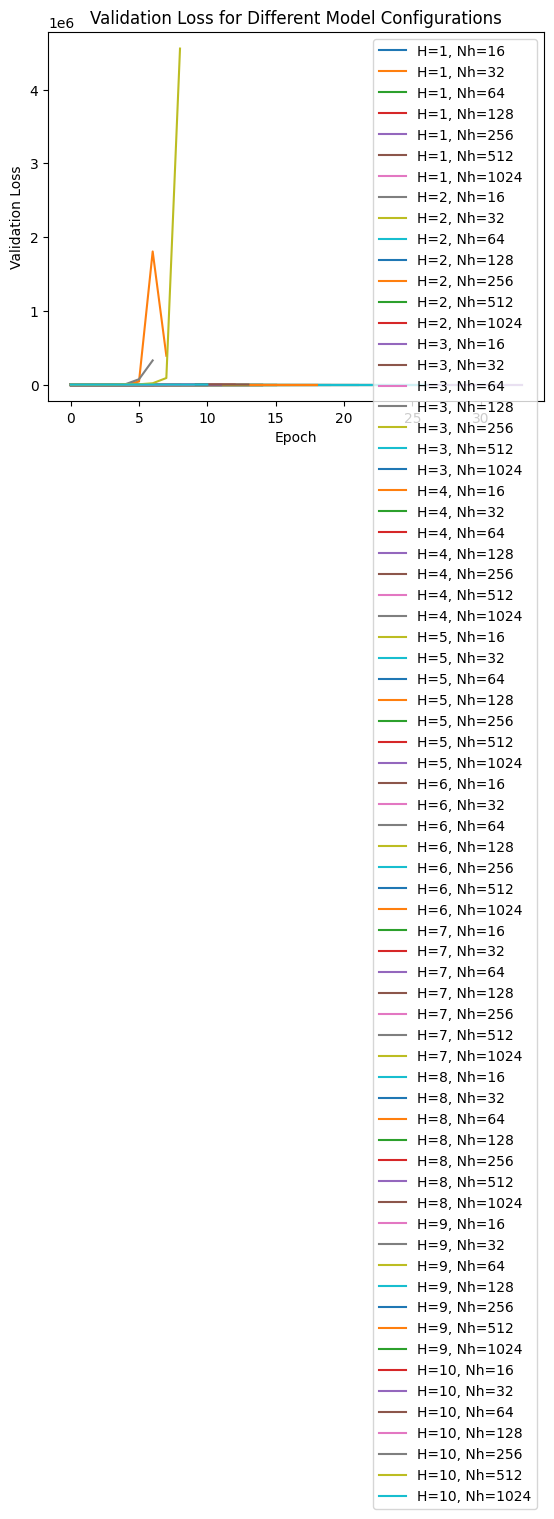

Model with H=1 and Nh=16:
MSE: 0.6265968084335327
MAE: 0.6265967038621006
RMSE: 4.066911395367891
R-squared: 0.8955285863241139
MAPE: 17.907965061773222%
Model with H=1 and Nh=32:
MSE: 0.6190970540046692
MAE: 0.6190972540102516
RMSE: 2.9397455427177785
R-squared: 0.9274537450970973
MAPE: 16.19143216080721%
Model with H=1 and Nh=64:
MSE: 0.5211517214775085
MAE: 0.5211517868389837
RMSE: 2.3811141792798383
R-squared: 0.9483135356150829
MAPE: 14.110040269276675%
Model with H=1 and Nh=128:
MSE: 0.4933047294616699
MAE: 0.49330505343714265
RMSE: 2.095916714663894
R-squared: 0.947496293681229
MAPE: 14.718506945916932%
Model with H=1 and Nh=256:
MSE: 0.435322642326355
MAE: 0.4353226992604551
RMSE: 1.9247939746480383
R-squared: 0.9763656947150536
MAPE: 12.218814356338726%
Model with H=1 and Nh=512:
MSE: 0.4233657121658325
MAE: 0.4233654101177021
RMSE: 2.003236027742635
R-squared: 0.9580745978570425
MAPE: 11.930948599224246%
Model with H=1 and Nh=1024:
MSE: 0.38290804624557495
MAE: 0.382908039038

In [4]:

# Iterate over different values of H and Nh
for H in H_values:
    for Nh in Nh_values:
        # Initialize a Sequential model
        model = tf.keras.Sequential()

        # Add the first hidden layer with batch normalization
        model.add(tf.keras.layers.Dense(Nh, activation='relu', input_shape=(4,)))  
        model.add(tf.keras.layers.BatchNormalization())

        # Add subsequent hidden layers with batch normalization
        for _ in range(H - 1):
            model.add(tf.keras.layers.Dense(Nh, activation='relu'))
            model.add(tf.keras.layers.BatchNormalization())

        # Output layer (assuming it follows the hidden layers)
        model.add(tf.keras.layers.Dense(7, activation='softplus'))  

        # Compile the model
        model.compile(optimizer='adam', loss='mean_absolute_error')

        # Train the model and store the training history
    # Train the model with given hyperparameters
        history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val), 
                        callbacks=[PrintEpochInfo(), lr_scheduler, early_stopping], verbose=0)
    
        histories[(H, Nh)] = history

        # Evaluate the model on the testing set
        predictions = model.predict(X_test)

        # Evaluate the model on the testing set and calculate MSE
        mse = model.evaluate(X_test, y_test)
        mses[(H, Nh)] = mse

        # Calculate Mean Absolute Error (MAE)
        mae = mean_absolute_error(y_test, predictions)
        maes[(H, Nh)] = mae

        # Calculate Root Mean Squared Error (RMSE)
        rmse = np.sqrt(mean_squared_error(y_test, predictions))
        rmses[(H, Nh)] = rmse

        # Calculate R-squared (R2) Score
        r2 = r2_score(y_test, predictions)
        r2_scores[(H, Nh)] = r2

        # Calculate Mean Absolute Percentage Error (MAPE)
        mape = np.mean(np.abs((y_test - predictions) / y_test)) * 100
        mapes[(H, Nh)] = mape

# Plot the validation loss for each configuration
for (H, Nh), history in histories.items():
    plt.plot(history.history['val_loss'], label=f'H={H}, Nh={Nh}')

plt.title('Validation Loss for Different Model Configurations')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.legend()
plt.show()

# Print the MSE for each configuration
# Print the evaluation metrics for each configuration
for (H, Nh), mse in mses.items():
    print(f'Model with H={H} and Nh={Nh}:')
    print(f'MSE: {mse}')
    print(f'MAE: {maes[(H, Nh)]}')
    print(f'RMSE: {rmses[(H, Nh)]}')
    print(f'R-squared: {r2_scores[(H, Nh)]}')
    print(f'MAPE: {mapes[(H, Nh)]}%')


### Ranking

In [5]:
# Rank combinations based on their MSE values
ranked_combinations = sorted(mses.items(), key=lambda x: x[1])

# Print ranked combinations
for idx, ((H, Nh), mse) in enumerate(ranked_combinations, start=1):
    print(f"Rank {idx}: Combination H={H}, Nh={Nh} - MSE: {mse}")


Rank 1: Combination H=6, Nh=256 - MSE: 0.19650597870349884
Rank 2: Combination H=4, Nh=128 - MSE: 0.21628442406654358
Rank 3: Combination H=4, Nh=256 - MSE: 0.2414274513721466
Rank 4: Combination H=6, Nh=128 - MSE: 0.2559279501438141
Rank 5: Combination H=7, Nh=64 - MSE: 0.27813419699668884
Rank 6: Combination H=5, Nh=256 - MSE: 0.29665935039520264
Rank 7: Combination H=4, Nh=64 - MSE: 0.3053044378757477
Rank 8: Combination H=9, Nh=64 - MSE: 0.30768752098083496
Rank 9: Combination H=3, Nh=256 - MSE: 0.3080404996871948
Rank 10: Combination H=5, Nh=32 - MSE: 0.3107946515083313
Rank 11: Combination H=5, Nh=64 - MSE: 0.31213831901550293
Rank 12: Combination H=8, Nh=64 - MSE: 0.31386059522628784
Rank 13: Combination H=7, Nh=128 - MSE: 0.31882333755493164
Rank 14: Combination H=5, Nh=128 - MSE: 0.3205721974372864
Rank 15: Combination H=3, Nh=128 - MSE: 0.347360759973526
Rank 16: Combination H=5, Nh=512 - MSE: 0.3490273952484131
Rank 17: Combination H=4, Nh=512 - MSE: 0.3616322875022888
Rank 

Rank 1: Combination H=5, Nh=256 - MSE: 0.2685861587524414
Rank 2: Combination H=5, Nh=512 - MSE: 0.26927897334098816
Rank 3: Combination H=4, Nh=1024 - MSE: 0.2832221984863281
Rank 4: Combination H=4, Nh=512 - MSE: 0.29064759612083435
Rank 5: Combination H=6, Nh=1024 - MSE: 0.3075002133846283
Rank 6: Combination H=7, Nh=256 - MSE: 0.32315966486930847
Rank 7: Combination H=3, Nh=256 - MSE: 0.3244527578353882
Rank 8: Combination H=4, Nh=128 - MSE: 0.32607361674308777
Rank 9: Combination H=4, Nh=256 - MSE: 0.3269226551055908
Rank 10: Combination H=5, Nh=1024 - MSE: 0.33056139945983887
Rank 11: Combination H=4, Nh=64 - MSE: 0.3360600769519806
Rank 12: Combination H=3, Nh=512 - MSE: 0.3548477292060852
Rank 13: Combination H=7, Nh=128 - MSE: 0.36053985357284546
Rank 14: Combination H=6, Nh=64 - MSE: 0.36217623949050903
Rank 15: Combination H=3, Nh=1024 - MSE: 0.3668963313102722

In [6]:
# Specify the combination you want to call
H = 6
Nh = 256

# Retrieve the model for the specified combination
selected_model = histories[(H, Nh)].model
selected_model.save("model_6_256_20_20_20_20.h5")
# Use the trained model to make predictions on the testing set
predictions = selected_model.predict(X_test)

# Evaluate the model on the testing set
mse = selected_model.evaluate(X_test, y_test)
print("Mean Squared Error on Testing Set:", mse)

# Print the first few predictions
print("Predictions:")
print(predictions[:5])

# Print the corresponding true values
print("True Values:")
print(y_test[:5])

 62/750 [=>............................] - ETA: 0s

d:\Software\Python\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


750/750 [==============================] - 1s 819us/step - loss: 0.1965
Mean Squared Error on Testing Set: 0.19650597870349884
Predictions:
[[1.0219637e+01 4.5056027e-01 1.6853890e+00 1.6735905e+00 6.7400590e-02
  1.5987738e+00 6.8811283e-02]
 [0.0000000e+00 1.7507122e-07 1.4677124e+00 1.4832344e+00 3.5829239e-03
  3.9988381e-01 1.2376591e-01]
 [7.4750261e+00 6.6595018e-01 1.7110184e+00 1.7082503e+00 5.5595353e-02
  1.6504406e+00 6.1348688e-02]
 [8.0876646e+00 2.6589451e+00 2.5022225e+00 2.4939084e+00 1.6155841e-02
  1.0894253e+00 5.4000672e-02]
 [1.5769609e+01 7.3881488e+00 1.6915892e+00 1.6767877e+00 9.1617201e-03
  6.3844192e-01 1.0877731e-01]]
True Values:
[[1.03131378e+01 4.13992151e-01 1.68153236e+00 1.68153236e+00
  7.19429836e-02 1.63623509e+00 6.50622125e-02]
 [1.57412647e+00 5.88833103e-01 1.55288744e+00 1.55288744e+00
  7.44111990e-03 4.64687549e-01 1.37156431e-01]
 [7.26807243e+00 7.49825031e-01 1.70935463e+00 1.70935463e+00
  5.27434900e-02 1.69007496e+00 5.96008677e-02]
 

# Split Dataset

 ## Delta current

In [8]:


# Fix random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Load your simulation data
# Replace "your_dataset.csv" with the path to your dataset
# df = pd.read_csv(r"D:\Krishna\ai-power-converter\dataset\simulation_results_23x13x13x13.csv")
df_1 = pd.read_csv(r"D:\Krishna\ai-power-converter\simulation_results_new_20_20_20_20.csv")

# Extract input features (L, C, fsw)
X_1 = df_1[['L', 'C', 'fsw', "t_dt"]].values

# Extract output (ripples)
y_1 = df_1[["delta_current"]].values  # Adjust column names as per your dataset

# Define custom scaling ranges for each input feature
L_min, L_max = 30e-6, 2000e-6
C_min, C_max = 20e-6, 1000e-6
fsw_min, fsw_max = 20e3, 200e3
t_dt_min, t_dt_max = 0.178e-6, 1e-6

X_scaled_1 = custom_scaling(X_1)
print(X_scaled[90:])

# Split the dataset into training, validation, and testing sets
X_train_1, X_temp_1, y_train_1, y_temp_1 = train_test_split(X_scaled_1, y_1, test_size=0.3, random_state=42)
X_val_1, X_test_1, y_val_1, y_test_1 = train_test_split(X_temp_1, y_temp_1, test_size=0.5, random_state=42)

# Define a custom callback to print custom information at the end of each epoch
class PrintEpochInfo(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        print(f"Epoch {epoch+1}/{self.params['epochs']}, Loss: {logs['loss']}, Val Loss: {logs['val_loss']}")


# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=5, verbose=1, mode='auto', restore_best_weights=True)

# Define the learning rate scheduler
lr_scheduler = ReduceLROnPlateau(factor=0.5, patience=3, min_lr=1e-6)# Initialize a dictionary to store the training history for each configuration


histories_1 = {}

# Initialize dictionaries to store the evaluation metrics for each configuration
mses_1 = {}
maes_1 = {}
rmses_1 = {}
r2_scores_1 = {}
mapes_1 = {}

# Define a list of different values for H and Nh to try
H_values = [1, 2, 3, 4, 5, 6]  # Number of hidden layers
Nh_values = [16, 32, 64, 128, 256]  # Number of neurons per hidden layer

[[0.         0.01020408 0.21052222 0.52676399]
 [0.         0.01020408 0.21052222 0.57907543]
 [0.         0.01020408 0.21052222 0.63138686]
 ...
 [1.         0.18367347 1.         0.89416058]
 [1.         0.18367347 1.         0.94768856]
 [1.         0.18367347 1.         1.        ]]


Epoch 1/100, Loss: 10.165595054626465, Val Loss: 6.153963088989258
Epoch 2/100, Loss: 6.963284015655518, Val Loss: 4.391519546508789
Epoch 3/100, Loss: 6.504806041717529, Val Loss: 3.6025853157043457
Epoch 4/100, Loss: 6.1640849113464355, Val Loss: 3.4557416439056396
Epoch 5/100, Loss: 6.10644006729126, Val Loss: 3.757643461227417
Epoch 6/100, Loss: 5.995914459228516, Val Loss: 3.2603466510772705
Epoch 7/100, Loss: 6.006052494049072, Val Loss: 3.4861857891082764
Epoch 8/100, Loss: 5.946771621704102, Val Loss: 3.3885152339935303
Epoch 9/100, Loss: 5.973564624786377, Val Loss: 3.880695343017578
Epoch 10/100, Loss: 5.874089241027832, Val Loss: 3.5335469245910645
Epoch 11/100, Loss: 5.865899085998535, Val Loss: 3.177640914916992
Epoch 12/100, Loss: 5.908913612365723, Val Loss: 3.707232713699341
Epoch 13/100, Loss: 5.9372992515563965, Val Loss: 3.752112865447998
Epoch 14/100, Loss: 5.866442680358887, Val Loss: 3.451861619949341
Epoch 15/100, Loss: 5.842118263244629, Val Loss: 3.595621824264

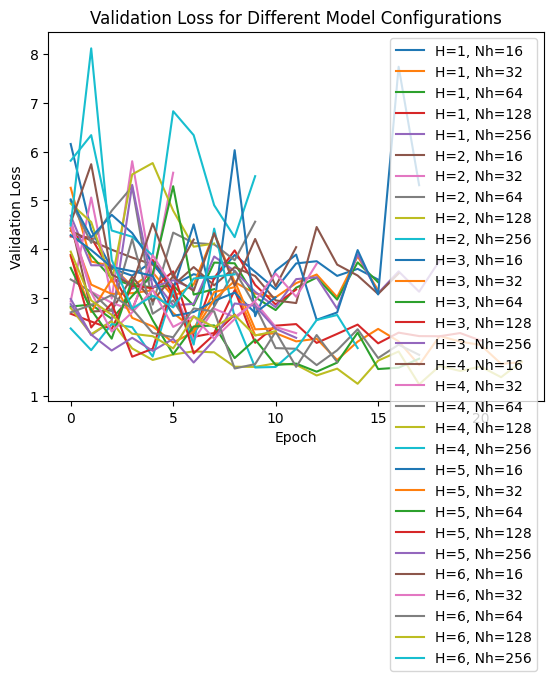

Model with H=1 and Nh=16:
MSE: 3.2551794052124023
MAE: 3.255181129877101
RMSE: 8.20280139395141
R-squared: 0.9636656037064678
MAPE: 35.33020427518914%
Model with H=1 and Nh=32:
MSE: 3.015904664993286
MAE: 3.0159057226824855
RMSE: 5.704008040928563
R-squared: 0.9824307260886099
MAPE: 38.23166172792356%
Model with H=1 and Nh=64:
MSE: 2.782947301864624
MAE: 2.782946178070837
RMSE: 5.656657417954469
R-squared: 0.9827212106289009
MAPE: 35.43154324368422%
Model with H=1 and Nh=128:
MSE: 2.2886316776275635
MAE: 2.288631341079218
RMSE: 5.633253380912241
R-squared: 0.9828638944866843
MAPE: 24.39016575248197%
Model with H=1 and Nh=256:
MSE: 2.7782514095306396
MAE: 2.778252473672358
RMSE: 5.296083679459039
R-squared: 0.9848538158601792
MAPE: 36.901690256231554%
Model with H=2 and Nh=16:
MSE: 2.922903299331665
MAE: 2.9229022832861187
RMSE: 8.768746394335983
R-squared: 0.958478926331345
MAPE: 28.859952818647827%
Model with H=2 and Nh=32:
MSE: 2.9894182682037354
MAE: 2.9894197756903336
RMSE: 11.0154

In [9]:

# Iterate over different values of H and Nh
for H in H_values:
    for Nh in Nh_values:
        # Initialize a Sequential model
        model_1 = tf.keras.Sequential()

        # Add the first hidden layer with batch normalization
        model_1.add(tf.keras.layers.Dense(Nh, activation='relu', input_shape=(4,)))  
        model_1.add(tf.keras.layers.BatchNormalization())

        # Add subsequent hidden layers with batch normalization
        for _ in range(H - 1):
            model_1.add(tf.keras.layers.Dense(Nh, activation='relu'))
            model_1.add(tf.keras.layers.BatchNormalization())

        # Output layer (assuming it follows the hidden layers)
        model_1.add(tf.keras.layers.Dense(1, activation='softplus'))  

        # Compile the model
        model_1.compile(optimizer='adam', loss='mean_absolute_error')

        # Train the model and store the training history
    # Train the model with given hyperparameters
        history_1 = model_1.fit(X_train_1, y_train_1, epochs=100, batch_size=32, validation_data=(X_val_1, y_val_1), 
                        callbacks=[PrintEpochInfo(), lr_scheduler, early_stopping], verbose=0)
    
        histories_1[(H, Nh)] = history_1

        # Evaluate the model on the testing set
        predictions_1 = model_1.predict(X_test_1)

        # Evaluate the model on the testing set and calculate MSE
        mse_1 = model_1.evaluate(X_test_1, y_test_1)
        mses_1[(H, Nh)] = mse_1

        # Calculate Mean Absolute Error (MAE)
        mae_1 = mean_absolute_error(y_test_1, predictions_1)
        maes_1[(H, Nh)] = mae_1

        # Calculate Root Mean Squared Error (RMSE)
        rmse_1 = np.sqrt(mean_squared_error(y_test_1, predictions_1))
        rmses_1[(H, Nh)] = rmse_1

        # Calculate R-squared (R2) Score
        r2_1 = r2_score(y_test_1, predictions_1)
        r2_scores_1[(H, Nh)] = r2_1

        # Calculate Mean Absolute Percentage Error (MAPE)
        mape_1 = np.mean(np.abs((y_test_1 - predictions_1) / y_test_1)) * 100
        mapes_1[(H, Nh)] = mape_1

# Plot the validation loss for each configuration
for (H, Nh), history_1 in histories_1.items():
    plt.plot(history_1.history['val_loss'], label=f'H={H}, Nh={Nh}')

plt.title('Validation Loss for Different Model Configurations')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.legend()
plt.show()

# Print the MSE for each configuration
# Print the evaluation metrics for each configuration
for (H, Nh), mse_1 in mses_1.items():
    print(f'Model with H={H} and Nh={Nh}:')
    print(f'MSE: {mse_1}')
    print(f'MAE: {maes_1[(H, Nh)]}')
    print(f'RMSE: {rmses_1[(H, Nh)]}')
    print(f'R-squared: {r2_scores_1[(H, Nh)]}')
    print(f'MAPE: {mapes_1[(H, Nh)]}%')


In [10]:
# Rank combinations based on their MSE values
ranked_combinations_1 = sorted(mses_1.items(), key=lambda x: x[1])

# Print ranked combinations
for idx, ((H, Nh), mse_1) in enumerate(ranked_combinations_1, start=1):
    print(f"Rank {idx}: Combination H={H}, Nh={Nh} - MSE: {mse_1}")


Rank 1: Combination H=4, Nh=128 - MSE: 1.2417047023773193
Rank 2: Combination H=5, Nh=64 - MSE: 1.5050452947616577
Rank 3: Combination H=6, Nh=64 - MSE: 1.615415334701538
Rank 4: Combination H=4, Nh=256 - MSE: 1.6375219821929932
Rank 5: Combination H=4, Nh=64 - MSE: 1.6430667638778687
Rank 6: Combination H=3, Nh=32 - MSE: 1.6762968301773071
Rank 7: Combination H=5, Nh=256 - MSE: 1.6902366876602173
Rank 8: Combination H=5, Nh=128 - MSE: 1.8024905920028687
Rank 9: Combination H=6, Nh=128 - MSE: 1.9744824171066284
Rank 10: Combination H=3, Nh=128 - MSE: 2.0792300701141357
Rank 11: Combination H=5, Nh=32 - MSE: 2.11503005027771
Rank 12: Combination H=4, Nh=32 - MSE: 2.1972804069519043
Rank 13: Combination H=6, Nh=32 - MSE: 2.2193119525909424
Rank 14: Combination H=3, Nh=256 - MSE: 2.220998525619507
Rank 15: Combination H=1, Nh=128 - MSE: 2.2886316776275635
Rank 16: Combination H=3, Nh=16 - MSE: 2.548496961593628
Rank 17: Combination H=3, Nh=64 - MSE: 2.597749948501587
Rank 18: Combination 

In [11]:
# Specify the combination you want to call
H = 4
Nh = 64

# Retrieve the model for the specified combination
selected_model_1 = histories_1[(H, Nh)].model
selected_model_1.save("model_4_128_delta_current_2.h5")
# Use the trained model to make predictions on the testing set
prediction_1 = selected_model_1.predict(X_test_1)

# Evaluate the model on the testing set
mse_1_1 = selected_model_1.evaluate(X_test_1, y_test_1)
print("Mean Squared Error on Testing Set:", mse_1_1)

# Print the first few predictions
print("Predictions:")
print(prediction_1[:5])

# Print the corresponding true values
print("True Values:")
print(y_test_1[:5])

152/750 [=====>........................] - ETA: 0s

d:\Software\Python\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


750/750 [==============================] - 0s 628us/step - loss: 1.6431
Mean Squared Error on Testing Set: 1.6430667638778687
Predictions:
[[ 9.419772 ]
 [ 0.       ]
 [ 7.2873015]
 [ 8.510252 ]
 [18.381678 ]]
True Values:
[[10.31313779]
 [ 1.57412647]
 [ 7.26807243]
 [ 7.08448658]
 [15.36642696]]


## Delta voltage

In [14]:


# Fix random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Load your simulation data
# Replace "your_dataset.csv" with the path to your dataset
# df = pd.read_csv(r"D:\Krishna\ai-power-converter\dataset\simulation_results_23x13x13x13.csv")
df_2 = pd.read_csv(r"D:\Krishna\ai-power-converter\simulation_results_new_20_20_20_20.csv")

# Extract input features (L, C, fsw)
X_2 = df_2[['L', 'C', 'fsw', "t_dt"]].values

# Extract output (ripples)
y_2 = df_2[["delta_voltage"]].values  # Adjust column names as per your dataset

# Define custom scaling ranges for each input feature
L_min, L_max = 30e-6, 2000e-6
C_min, C_max = 20e-6, 1000e-6
fsw_min, fsw_max = 20e3, 200e3
t_dt_min, t_dt_max = 0.178e-6, 1e-6

X_scaled_2 = custom_scaling(X_2)
print(X_scaled[90:])

# Split the dataset into training, validation, and testing sets
X_train_2, X_temp_2, y_train_2, y_temp_2 = train_test_split(X_scaled_2, y_2, test_size=0.3, random_state=42)
X_val_2, X_test_2, y_val_2, y_test_2 = train_test_split(X_temp_2, y_temp_2, test_size=0.5, random_state=42)

# Define a custom callback to print custom information at the end of each epoch
class PrintEpochInfo(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        print(f"Epoch {epoch+1}/{self.params['epochs']}, Loss: {logs['loss']}, Val Loss: {logs['val_loss']}")


# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=5, verbose=1, mode='auto', restore_best_weights=True)

# Define the learning rate scheduler
lr_scheduler = ReduceLROnPlateau(factor=0.5, patience=3, min_lr=1e-6)# Initialize a dictionary to store the training history for each configuration


histories_2 = {}

# Initialize dictionaries to store the evaluation metrics for each configuration
mses_2 = {}
maes_2 = {}
rmses_2 = {}
r2_scores_2 = {}
mapes_2 = {}

# Define a list of different values for H and Nh to try
H_values = [1, 2, 3, 4, 5, 6]  # Number of hidden layers
Nh_values = [16, 32, 64, 128, 256]  # Number of neurons per hidden layer

[[0.         0.01020408 0.21052222 0.52676399]
 [0.         0.01020408 0.21052222 0.57907543]
 [0.         0.01020408 0.21052222 0.63138686]
 ...
 [1.         0.18367347 1.         0.89416058]
 [1.         0.18367347 1.         0.94768856]
 [1.         0.18367347 1.         1.        ]]


Epoch 1/100, Loss: 1.1644072532653809, Val Loss: 0.976916491985321
Epoch 2/100, Loss: 0.9289585947990417, Val Loss: 0.6715440154075623
Epoch 3/100, Loss: 0.7507679462432861, Val Loss: 0.6237688064575195
Epoch 4/100, Loss: 0.7270164489746094, Val Loss: 0.5973473191261292
Epoch 5/100, Loss: 0.7297140955924988, Val Loss: 0.5877227783203125
Epoch 6/100, Loss: 0.721774160861969, Val Loss: 0.5801249146461487
Epoch 7/100, Loss: 0.7157199382781982, Val Loss: 0.6078788638114929
Epoch 8/100, Loss: 0.7093208432197571, Val Loss: 0.5839875340461731
Epoch 9/100, Loss: 0.7057238221168518, Val Loss: 0.5694718956947327
Epoch 10/100, Loss: 0.700571596622467, Val Loss: 0.562211811542511
Epoch 11/100, Loss: 0.6962318420410156, Val Loss: 0.5879817605018616
Epoch 12/100, Loss: 0.6980476379394531, Val Loss: 0.5989370346069336
Epoch 13/100, Loss: 0.6959878206253052, Val Loss: 0.5692993998527527
Epoch 14/100, Loss: 0.689322292804718, Val Loss: 0.5487571358680725
Epoch 15/100, Loss: 0.6895160675048828, Val Loss

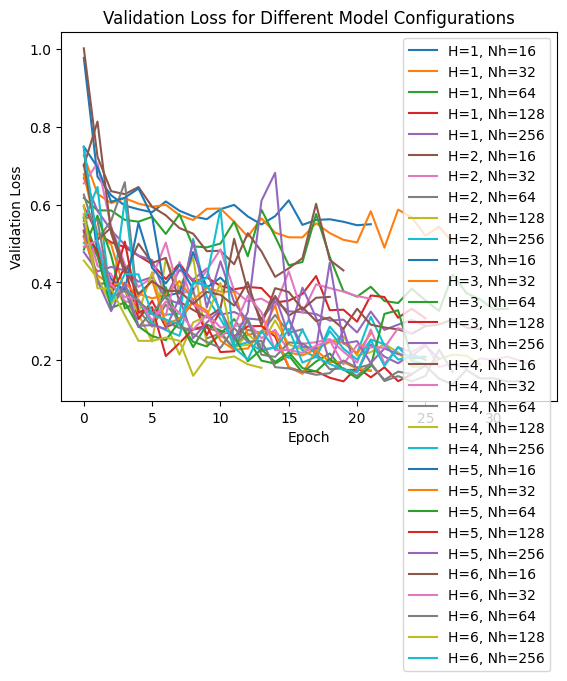

Model with H=1 and Nh=16:
MSE: 0.5483890771865845
MAE: 0.5483888675608601
RMSE: 0.9370659309759224
R-squared: 0.9126373170825682
MAPE: 19.15630584001827%
Model with H=1 and Nh=32:
MSE: 0.4895777702331543
MAE: 0.48957736086242465
RMSE: 0.8395056646862789
R-squared: 0.9298814498166601
MAPE: 16.142052893078684%
Model with H=1 and Nh=64:
MSE: 0.32540544867515564
MAE: 0.3254052911192886
RMSE: 0.5416980434876574
R-squared: 0.9708055565908045
MAPE: 11.949617616393445%
Model with H=1 and Nh=128:
MSE: 0.2952343821525574
MAE: 0.29523460050384087
RMSE: 0.4874959456613856
R-squared: 0.9763556335173539
MAPE: 12.512701746231311%
Model with H=1 and Nh=256:
MSE: 0.26816314458847046
MAE: 0.2681633488394019
RMSE: 0.4734613163429719
R-squared: 0.9776974424710788
MAPE: 11.28658830630103%
Model with H=2 and Nh=16:
MSE: 0.4071269631385803
MAE: 0.40712686469058446
RMSE: 0.8406731895055262
R-squared: 0.9296862824051952
MAPE: 14.930265936594122%
Model with H=2 and Nh=32:
MSE: 0.31684616208076477
MAE: 0.3168459

In [15]:

# Iterate over different values of H and Nh
for H in H_values:
    for Nh in Nh_values:
        # Initialize a Sequential model
        model_2 = tf.keras.Sequential()

        # Add the first hidden layer with batch normalization
        model_2.add(tf.keras.layers.Dense(Nh, activation='relu', input_shape=(4,)))  
        model_2.add(tf.keras.layers.BatchNormalization())

        # Add subsequent hidden layers with batch normalization
        for _ in range(H - 1):
            model_2.add(tf.keras.layers.Dense(Nh, activation='relu'))
            model_2.add(tf.keras.layers.BatchNormalization())

        # Output layer (assuming it follows the hidden layers)
        model_2.add(tf.keras.layers.Dense(1, activation='softplus'))  

        # Compile the model
        model_2.compile(optimizer='adam', loss='mean_absolute_error')

        # Train the model and store the training history
    # Train the model with given hyperparameters
        history_2 = model_2.fit(X_train_2, y_train_2, epochs=100, batch_size=32, validation_data=(X_val_2, y_val_2), 
                        callbacks=[PrintEpochInfo(), lr_scheduler, early_stopping], verbose=0)
    
        histories_2[(H, Nh)] = history_2

        # Evaluate the model on the testing set
        predictions_2 = model_2.predict(X_test_2)

        # Evaluate the model on the testing set and calculate MSE
        mse_2 = model_2.evaluate(X_test_2, y_test_2)
        mses_2[(H, Nh)] = mse_2

        # Calculate Mean Absolute Error (MAE)
        mae_2 = mean_absolute_error(y_test_2, predictions_2)
        maes_2[(H, Nh)] = mae_2

        # Calculate Root Mean Squared Error (RMSE)
        rmse_2 = np.sqrt(mean_squared_error(y_test_2, predictions_2))
        rmses_2[(H, Nh)] = rmse_2

        # Calculate R-squared (R2) Score
        r2_2 = r2_score(y_test_2, predictions_2)
        r2_scores_2[(H, Nh)] = r2_2

        # Calculate Mean Absolute Percentage Error (MAPE)
        mape_2 = np.mean(np.abs((y_test_2- predictions_2) / y_test_2)) * 100
        mapes_2[(H, Nh)] = mape_2

# Plot the validation loss for each configuration
for (H, Nh), history_2 in histories_2.items():
    plt.plot(history_2.history['val_loss'], label=f'H={H}, Nh={Nh}')

plt.title('Validation Loss for Different Model Configurations')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.legend()
plt.show()

# Print the MSE for each configuration
# Print the evaluation metrics for each configuration
for (H, Nh), mse_2 in mses_2.items():
    print(f'Model with H={H} and Nh={Nh}:')
    print(f'MSE: {mse_2}')
    print(f'MAE: {maes_2[(H, Nh)]}')
    print(f'RMSE: {rmses_2[(H, Nh)]}')
    print(f'R-squared: {r2_scores_2[(H, Nh)]}')
    print(f'MAPE: {mapes_2[(H, Nh)]}%')


In [16]:
# Rank combinations based on their MSE values
ranked_combinations_2 = sorted(mses_2.items(), key=lambda x: x[1])

# Print ranked combinations
for idx, ((H, Nh), mse_2) in enumerate(ranked_combinations_2, start=1):
    print(f"Rank {idx}: Combination H={H}, Nh={Nh} - MSE: {mse_2}")


Rank 1: Combination H=6, Nh=64 - MSE: 0.13641951978206635
Rank 2: Combination H=4, Nh=64 - MSE: 0.14245405793190002
Rank 3: Combination H=3, Nh=128 - MSE: 0.1440345197916031
Rank 4: Combination H=5, Nh=64 - MSE: 0.15323308110237122
Rank 5: Combination H=6, Nh=128 - MSE: 0.15775881707668304
Rank 6: Combination H=6, Nh=256 - MSE: 0.1592685878276825
Rank 7: Combination H=3, Nh=256 - MSE: 0.16115054488182068
Rank 8: Combination H=5, Nh=32 - MSE: 0.1642686426639557
Rank 9: Combination H=3, Nh=64 - MSE: 0.1692153364419937
Rank 10: Combination H=4, Nh=32 - MSE: 0.17687559127807617
Rank 11: Combination H=2, Nh=128 - MSE: 0.1795548051595688
Rank 12: Combination H=5, Nh=256 - MSE: 0.18306505680084229
Rank 13: Combination H=6, Nh=32 - MSE: 0.18702752888202667
Rank 14: Combination H=4, Nh=256 - MSE: 0.19750788807868958
Rank 15: Combination H=5, Nh=128 - MSE: 0.2013651579618454
Rank 16: Combination H=2, Nh=256 - MSE: 0.2018645852804184
Rank 17: Combination H=4, Nh=128 - MSE: 0.2120571732521057
Rank

In [18]:
# Specify the combination you want to call
H = 6
Nh = 64

# Retrieve the model for the specified combination
selected_model_2 = histories_2[(H, Nh)].model
selected_model_2.save("model_4_64_delta_voltage_2.h5")
# Use the trained model to make predictions on the testing set
prediction_2 = selected_model_2.predict(X_test_2)

# Evaluate the model on the testing set
mse_2_2 = selected_model_2.evaluate(X_test_2, y_test_2)
print("Mean Squared Error on Testing Set:", mse_2_2)

# Print the first few predictions
print("Predictions:")
print(prediction_2[:5])

# Print the corresponding true values
print("True Values:")
print(y_test_2[:5])

750/750 [==============================] - 0s 643us/step - loss: 0.1364
Mean Squared Error on Testing Set: 0.13641951978206635
Predictions:
[[0.5265238]
 [0.5116302]
 [0.8646212]
 [2.7762036]
 [7.5426183]]
True Values:
[[0.41399215]
 [0.5888331 ]
 [0.74982503]
 [2.85925887]
 [7.91764236]]


## Pl_s1, Pl_s2

In [19]:


# Fix random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Load your simulation data
# Replace "your_dataset.csv" with the path to your dataset
# df = pd.read_csv(r"D:\Krishna\ai-power-converter\dataset\simulation_results_33x13x13x13.csv")
df_3 = pd.read_csv(r"D:\Krishna\ai-power-converter\simulation_results_new_20_20_20_20.csv")

# Extract input features (L, C, fsw)
X_3 = df_3[['L', 'C', 'fsw', "t_dt"]].values

# Extract output (ripples)
y_3 = df_3[["Pl_s1"]].values  # Adjust column names as per your dataset

# Define custom scaling ranges for each input feature
L_min, L_max = 30e-6, 2000e-6
C_min, C_max = 20e-6, 1000e-6
fsw_min, fsw_max = 20e3, 200e3
t_dt_min, t_dt_max = 0.178e-6, 1e-6

X_scaled_3 = custom_scaling(X_3)
print(X_scaled_3[90:])

# Split the dataset into training, validation, and testing sets
X_train_3, X_temp_3, y_train_3, y_temp_3 = train_test_split(X_scaled_3, y_3, test_size=0.3, random_state=42)
X_val_3, X_test_3, y_val_3, y_test_3 = train_test_split(X_temp_3, y_temp_3, test_size=0.5, random_state=42)

# Define a custom callback to print custom information at the end of each epoch
class PrintEpochInfo(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        print(f"Epoch {epoch+1}/{self.params['epochs']}, Loss: {logs['loss']}, Val Loss: {logs['val_loss']}")


# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=5, verbose=1, mode='auto', restore_best_weights=True)

# Define the learning rate scheduler
lr_scheduler = ReduceLROnPlateau(factor=0.5, patience=3, min_lr=1e-6)# Initialize a dictionary to store the training history for each configuration


histories_3 = {}

# Initialize dictionaries to store the evaluation metrics for each configuration
mses_3 = {}
maes_3 = {}
rmses_3 = {}
r2_scores_3 = {}
mapes_3 = {}

# Define a list of different values for H and Nh to try
H_values = [1, 2, 3, 4, 5, 6]  # Number of hidden layers
Nh_values = [16, 32, 64, 128, 256]  # Number of neurons per hidden layer

[[0.         0.01020408 0.21052222 0.52676399]
 [0.         0.01020408 0.21052222 0.57907543]
 [0.         0.01020408 0.21052222 0.63138686]
 ...
 [1.         0.18367347 1.         0.89416058]
 [1.         0.18367347 1.         0.94768856]
 [1.         0.18367347 1.         1.        ]]


Epoch 1/100, Loss: 0.1305452138185501, Val Loss: 0.05539017170667648
Epoch 2/100, Loss: 0.07987677305936813, Val Loss: 0.054913945496082306
Epoch 3/100, Loss: 0.07727009803056717, Val Loss: 0.053084127604961395
Epoch 4/100, Loss: 0.07562414556741714, Val Loss: 0.06609723716974258
Epoch 5/100, Loss: 0.07590539753437042, Val Loss: 0.04661107435822487
Epoch 6/100, Loss: 0.07440377026796341, Val Loss: 0.040902432054281235
Epoch 7/100, Loss: 0.07420391589403152, Val Loss: 0.052123259752988815
Epoch 8/100, Loss: 0.07391209155321121, Val Loss: 0.05481543391942978
Epoch 9/100, Loss: 0.07364396750926971, Val Loss: 0.04468536376953125
Epoch 10/100, Loss: 0.07314104586839676, Val Loss: 0.04328034445643425
Epoch 11/100, Loss: 0.07138355821371078, Val Loss: 0.039063673466444016
Epoch 12/100, Loss: 0.0710153877735138, Val Loss: 0.03826450929045677
Epoch 13/100, Loss: 0.07150058448314667, Val Loss: 0.03713215887546539
Epoch 14/100, Loss: 0.07157208025455475, Val Loss: 0.05708105117082596
Epoch 15/100

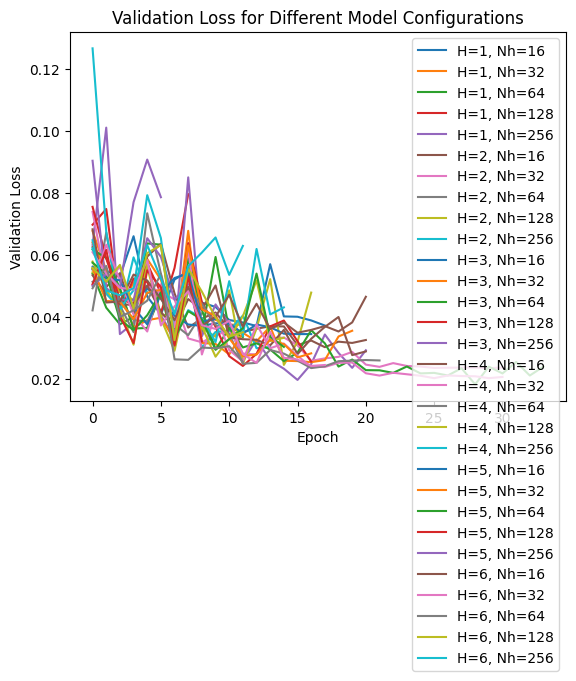

Model with H=1 and Nh=16:
MSE: 0.036867670714855194
MAE: 0.03686767460409008
RMSE: 0.05372442272097558
R-squared: 0.9825567753382985
MAPE: 1.9417564123838067%
Model with H=1 and Nh=32:
MSE: 0.0371379479765892
MAE: 0.03713793763326696
RMSE: 0.05265104819466759
R-squared: 0.9832468181547014
MAPE: 1.972711334463258%
Model with H=1 and Nh=64:
MSE: 0.03385958448052406
MAE: 0.03385961031740157
RMSE: 0.04956659668395231
R-squared: 0.9851522221735932
MAPE: 1.7644885590916877%
Model with H=1 and Nh=128:
MSE: 0.04229707643389702
MAE: 0.042297083487471604
RMSE: 0.057374372279631214
R-squared: 0.9801061356067756
MAPE: 2.272321742836648%
Model with H=1 and Nh=256:
MSE: 0.019672559574246407
MAE: 0.019672571836889703
RMSE: 0.03446578819187488
R-squared: 0.9928210704962758
MAPE: 1.0031240327751043%
Model with H=2 and Nh=16:
MSE: 0.03131437301635742
MAE: 0.031314382730988854
RMSE: 0.04809630768829059
R-squared: 0.986020014092256
MAPE: 1.6428131171224658%
Model with H=2 and Nh=32:
MSE: 0.023209439590573

In [20]:

# Iterate over different values of H and Nh
for H in H_values:
    for Nh in Nh_values:
        # Initialize a Sequential model
        model_3 = tf.keras.Sequential()

        # Add the first hidden layer with batch normalization
        model_3.add(tf.keras.layers.Dense(Nh, activation='relu', input_shape=(4,)))  
        model_3.add(tf.keras.layers.BatchNormalization())

        # Add subsequent hidden layers with batch normalization
        for _ in range(H - 1):
            model_3.add(tf.keras.layers.Dense(Nh, activation='relu'))
            model_3.add(tf.keras.layers.BatchNormalization())

        # Output layer (assuming it follows the hidden layers)
        model_3.add(tf.keras.layers.Dense(1, activation='softplus'))  

        # Compile the model
        model_3.compile(optimizer='adam', loss='mean_absolute_error')

        # Train the model and store the training history
    # Train the model with given hyperparameters
        history_3 = model_3.fit(X_train_3, y_train_3, epochs=100, batch_size=32, validation_data=(X_val_3, y_val_3), 
                        callbacks=[PrintEpochInfo(), lr_scheduler, early_stopping], verbose=0)
    
        histories_3[(H, Nh)] = history_3

        # Evaluate the model on the testing set
        predictions_3 = model_3.predict(X_test_3)

        # Evaluate the model on the testing set and calculate MSE
        mse_3 = model_3.evaluate(X_test_3, y_test_3)
        mses_3[(H, Nh)] = mse_3

        # Calculate Mean Absolute Error (MAE)
        mae_3 = mean_absolute_error(y_test_3, predictions_3)
        maes_3[(H, Nh)] = mae_3

        # Calculate Root Mean Squared Error (RMSE)
        rmse_3 = np.sqrt(mean_squared_error(y_test_3, predictions_3))
        rmses_3[(H, Nh)] = rmse_3

        # Calculate R-squared (R2) Score
        r2_3 = r2_score(y_test_3, predictions_3)
        r2_scores_3[(H, Nh)] = r2_3

        # Calculate Mean Absolute Percentage Error (MAPE)
        mape_3 = np.mean(np.abs((y_test_3 - predictions_3) / y_test_3)) * 100
        mapes_3[(H, Nh)] = mape_3

# Plot the validation loss for each configuration
for (H, Nh), history_3 in histories_3.items():
    plt.plot(history_3.history['val_loss'], label=f'H={H}, Nh={Nh}')

plt.title('Validation Loss for Different Model Configurations')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.legend()
plt.show()

# Print the MSE for each configuration
# Print the evaluation metrics for each configuration
for (H, Nh), mse_3 in mses_3.items():
    print(f'Model with H={H} and Nh={Nh}:')
    print(f'MSE: {mse_3}')
    print(f'MAE: {maes_3[(H, Nh)]}')
    print(f'RMSE: {rmses_3[(H, Nh)]}')
    print(f'R-squared: {r2_scores_3[(H, Nh)]}')
    print(f'MAPE: {mapes_3[(H, Nh)]}%')


In [22]:
# Rank combinations based on their MSE values
ranked_combinations_3 = sorted(mses_3.items(), key=lambda x: x[1])
# Print ranked combinations
for idx, ((H, Nh), mse_3) in enumerate(ranked_combinations_3, start=1):
    print(f"Rank {idx}: Combination H={H}, Nh={Nh} - MSE: {mse_3}")


Rank 1: Combination H=3, Nh=64 - MSE: 0.018307030200958252
Rank 2: Combination H=1, Nh=256 - MSE: 0.019672559574246407
Rank 3: Combination H=4, Nh=32 - MSE: 0.02019079402089119
Rank 4: Combination H=4, Nh=64 - MSE: 0.02303217351436615
Rank 5: Combination H=2, Nh=32 - MSE: 0.02320943959057331
Rank 6: Combination H=3, Nh=128 - MSE: 0.02403581701219082
Rank 7: Combination H=2, Nh=128 - MSE: 0.0247215423732996
Rank 8: Combination H=6, Nh=32 - MSE: 0.025257280096411705
Rank 9: Combination H=3, Nh=32 - MSE: 0.02579178288578987
Rank 10: Combination H=6, Nh=64 - MSE: 0.02609545923769474
Rank 11: Combination H=4, Nh=128 - MSE: 0.027065061032772064
Rank 12: Combination H=5, Nh=32 - MSE: 0.027308491989970207
Rank 13: Combination H=4, Nh=16 - MSE: 0.027810556814074516
Rank 14: Combination H=5, Nh=64 - MSE: 0.029221534729003906
Rank 15: Combination H=2, Nh=256 - MSE: 0.029926355928182602
Rank 16: Combination H=2, Nh=16 - MSE: 0.03131437301635742
Rank 17: Combination H=5, Nh=128 - MSE: 0.03148842975

In [26]:
# Specify the combination you want to call
H = 3
Nh = 64

# Retrieve the model for the specified combination
selected_model_3 = histories_3[(H, Nh)].model
selected_model_3.save("model_3_64_Pls1_2.h5")
# Use the trained model to make predictions on the testing set
prediction_3 = selected_model_3.predict(X_test_3)

# Evaluate the model on the testing set
mse_3_3 = selected_model_3.evaluate(X_test_3, y_test_3)
print("Mean Squared Error on Testing Set:", mse_3_3)

# Print the first few predictions
print("Predictions:")
print(prediction_3[:5])

# Print the corresponding true values
print("True Values:")
print(y_test_3[:5])

750/750 [==============================] - 0s 556us/step - loss: 0.0183
Mean Squared Error on Testing Set: 0.018307030200958252
Predictions:
[[1.7021679]
 [1.5459187]
 [1.71748  ]
 [2.5178094]
 [1.6595656]]
True Values:
[[1.68153236]
 [1.55288744]
 [1.70935463]
 [2.53994796]
 [1.67185702]]


## Pl_C

In [31]:


# Fix random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Load your simulation data
# Replace "your_dataset.csv" with the path to your dataset
# df = pd.read_csv(r"D:\Krishna\ai-power-converter\dataset\simulation_results_43x13x13x13.csv")
df_4 = pd.read_csv(r"D:\Krishna\ai-power-converter\simulation_results_new_20_20_20_20.csv")

# Extract input features (L, C, fsw)
X_4 = df_4[['L', 'C', 'fsw', "t_dt"]].values

# Extract output (ripples)
y_4 = df_4[["Pl_C"]].values  # Adjust column names as per your dataset

# Define custom scaling ranges for each input feature
L_min, L_max = 30e-6, 2000e-6
C_min, C_max = 20e-6, 1000e-6
fsw_min, fsw_max = 20e3, 200e3
t_dt_min, t_dt_max = 0.178e-6, 1e-6

X_scaled_4 = custom_scaling(X_4)
print(X_scaled[90:])

# Split the dataset into training, validation, and testing sets
X_train_4, X_temp_4, y_train_4, y_temp_4 = train_test_split(X_scaled_4, y_4, test_size=0.3, random_state=42)
X_val_4, X_test_4, y_val_4, y_test_4 = train_test_split(X_temp_4, y_temp_4, test_size=0.5, random_state=42)

# Define a custom callback to print custom information at the end of each epoch
class PrintEpochInfo(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        print(f"Epoch {epoch+1}/{self.params['epochs']}, Loss: {logs['loss']}, Val Loss: {logs['val_loss']}")


# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=5, verbose=1, mode='auto', restore_best_weights=True)

# Define the learning rate scheduler
lr_scheduler = ReduceLROnPlateau(factor=0.5, patience=3, min_lr=1e-6)# Initialize a dictionary to store the training history for each configuration


histories_4 = {}

# Initialize dictionaries to store the evaluation metrics for each configuration
mses_4 = {}
maes_4 = {}
rmses_4 = {}
r2_scores_4 = {}
mapes_4 = {}

# Define a list of different values for H and Nh to try
H_values = [1, 2, 3, 4, 5, 6]  # Number of hidden layers
Nh_values = [16, 32, 64, 128, 256]  # Number of neurons per hidden layer

[[0.         0.01020408 0.21052222 0.52676399]
 [0.         0.01020408 0.21052222 0.57907543]
 [0.         0.01020408 0.21052222 0.63138686]
 ...
 [1.         0.18367347 1.         0.89416058]
 [1.         0.18367347 1.         0.94768856]
 [1.         0.18367347 1.         1.        ]]


Epoch 1/100, Loss: 0.03565352410078049, Val Loss: 0.003665095428004861
Epoch 2/100, Loss: 0.006376734934747219, Val Loss: 0.004209978971630335
Epoch 3/100, Loss: 0.006205410230904818, Val Loss: 0.0037395423278212547
Epoch 4/100, Loss: 0.006115596275776625, Val Loss: 0.003163837129250169
Epoch 5/100, Loss: 0.006119180005043745, Val Loss: 0.002939739264547825
Epoch 6/100, Loss: 0.006002048030495644, Val Loss: 0.0030154171399772167
Restoring model weights from the end of the best epoch: 1.
Epoch 6: early stopping
750/750 [==============================] - 0s 502us/step - loss: 0.0037
Epoch 1/100, Loss: 0.03599907457828522, Val Loss: 0.004880760330706835
Epoch 2/100, Loss: 0.006831347942352295, Val Loss: 0.0031178409699350595
Epoch 3/100, Loss: 0.006155551411211491, Val Loss: 0.002966683590784669
Epoch 4/100, Loss: 0.0059707630425691605, Val Loss: 0.0025443618651479483
Epoch 5/100, Loss: 0.005960618611425161, Val Loss: 0.004015600308775902
Epoch 6/100, Loss: 0.005867259111255407, Val Loss:

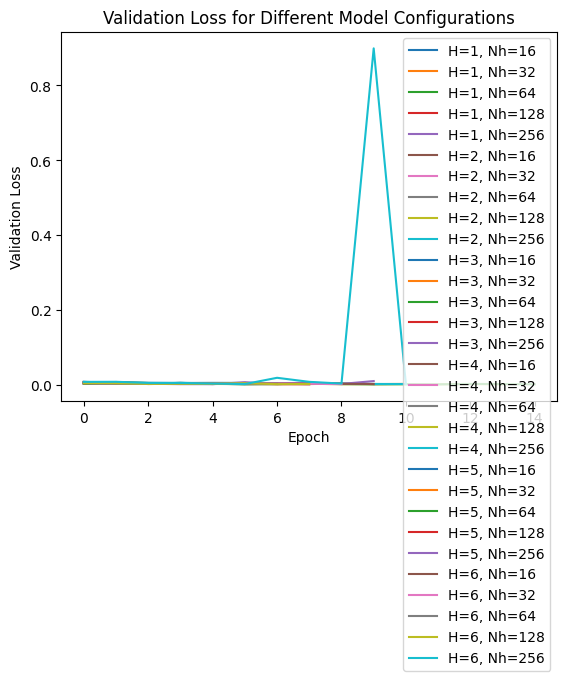

Model with H=1 and Nh=16:
MSE: 0.0036680083721876144
MAE: 0.0036680091120946797
RMSE: 0.00845318431860778
R-squared: 0.9711253936636748
MAPE: 28.572933517731492%
Model with H=1 and Nh=32:
MSE: 0.0031346797477453947
MAE: 0.0031346806621566684
RMSE: 0.008426111838186113
R-squared: 0.9713100472623906
MAPE: 19.179846712447322%
Model with H=1 and Nh=64:
MSE: 0.002854634542018175
MAE: 0.0028546340238726404
RMSE: 0.007850798043795902
R-squared: 0.9750940560895138
MAPE: 17.33122484622344%
Model with H=1 and Nh=128:
MSE: 0.002829468809068203
MAE: 0.0028294673597696017
RMSE: 0.006857672662314747
R-squared: 0.9809967055930024
MAPE: 19.873767355646816%
Model with H=1 and Nh=256:
MSE: 0.0030382825061678886
MAE: 0.003038281985145954
RMSE: 0.007891904808584265
R-squared: 0.9748325583189152
MAPE: 16.153446675396868%
Model with H=2 and Nh=16:
MSE: 0.003333475673571229
MAE: 0.0033334760954271303
RMSE: 0.008608020503816444
R-squared: 0.9700579190535731
MAPE: 14.494192706406636%
Model with H=2 and Nh=32:


In [32]:

# Iterate over different values of H and Nh
for H in H_values:
    for Nh in Nh_values:
        # Initialize a Sequential model
        model_4 = tf.keras.Sequential()

        # Add the first hidden layer with batch normalization
        model_4.add(tf.keras.layers.Dense(Nh, activation='relu', input_shape=(4,)))  
        model_4.add(tf.keras.layers.BatchNormalization())

        # Add subsequent hidden layers with batch normalization
        for _ in range(H - 1):
            model_4.add(tf.keras.layers.Dense(Nh, activation='relu'))
            model_4.add(tf.keras.layers.BatchNormalization())

        # Output layer (assuming it follows the hidden layers)
        model_4.add(tf.keras.layers.Dense(1, activation='softplus'))  

        # Compile the model
        model_4.compile(optimizer='adam', loss='mean_absolute_error')

        # Train the model and store the training history
    # Train the model with given hyperparameters
        history_4 = model_4.fit(X_train_4, y_train_4, epochs=100, batch_size=32, validation_data=(X_val_4, y_val_4), 
                        callbacks=[PrintEpochInfo(), lr_scheduler, early_stopping], verbose=0)
    
        histories_4[(H, Nh)] = history_4

        # Evaluate the model on the testing set
        predictions_4 = model_4.predict(X_test_4)

        # Evaluate the model on the testing set and calculate MSE
        mse_4 = model_4.evaluate(X_test_4, y_test_4)
        mses_4[(H, Nh)] = mse_4

        # Calculate Mean Absolute Error (MAE)
        mae_4 = mean_absolute_error(y_test_4, predictions_4)
        maes_4[(H, Nh)] = mae_4

        # Calculate Root Mean Squared Error (RMSE)
        rmse_4 = np.sqrt(mean_squared_error(y_test_4, predictions_4))
        rmses_4[(H, Nh)] = rmse_4

        # Calculate R-squared (R2) Score
        r2_4 = r2_score(y_test_4, predictions_4)
        r2_scores_4[(H, Nh)] = r2_4

        # Calculate Mean Absolute Percentage Error (MAPE)
        mape_4 = np.mean(np.abs((y_test_4 - predictions_4) / y_test_4)) * 100
        mapes_4[(H, Nh)] = mape_4

# Plot the validation loss for each configuration
for (H, Nh), history_4 in histories_4.items():
    plt.plot(history_4.history['val_loss'], label=f'H={H}, Nh={Nh}')

plt.title('Validation Loss for Different Model Configurations')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.legend()
plt.show()

# Print the MSE for each configuration
# Print the evaluation metrics for each configuration
for (H, Nh), mse_4 in mses_4.items():
    print(f'Model with H={H} and Nh={Nh}:')
    print(f'MSE: {mse_4}')
    print(f'MAE: {maes_4[(H, Nh)]}')
    print(f'RMSE: {rmses_4[(H, Nh)]}')
    print(f'R-squared: {r2_scores_4[(H, Nh)]}')
    print(f'MAPE: {mapes_4[(H, Nh)]}%')


In [34]:
# Rank combinations based on their MSE values
ranked_combinations_4 = sorted(mses_4.items(), key=lambda x: x[1])

# Print ranked combinations
for idx, ((H, Nh), mse_4) in enumerate(ranked_combinations_4, start=1):
    print(f"Rank {idx}: Combination H={H}, Nh={Nh} - MSE: {mse_4}")


Rank 1: Combination H=3, Nh=64 - MSE: 0.0014111388009041548
Rank 2: Combination H=2, Nh=128 - MSE: 0.0016791358357295394
Rank 3: Combination H=4, Nh=256 - MSE: 0.0017666940111666918
Rank 4: Combination H=3, Nh=256 - MSE: 0.0018681950168684125
Rank 5: Combination H=6, Nh=256 - MSE: 0.0021107851061969995
Rank 6: Combination H=5, Nh=256 - MSE: 0.002188729355111718
Rank 7: Combination H=4, Nh=128 - MSE: 0.0022162548266351223
Rank 8: Combination H=4, Nh=16 - MSE: 0.0023212269879877567
Rank 9: Combination H=3, Nh=128 - MSE: 0.0023265087511390448
Rank 10: Combination H=5, Nh=128 - MSE: 0.0023370871786028147
Rank 11: Combination H=6, Nh=32 - MSE: 0.002430119551718235
Rank 12: Combination H=4, Nh=64 - MSE: 0.00243521761149168
Rank 13: Combination H=3, Nh=32 - MSE: 0.002537474734708667
Rank 14: Combination H=6, Nh=64 - MSE: 0.002608171897009015
Rank 15: Combination H=5, Nh=64 - MSE: 0.0026874670293182135
Rank 16: Combination H=6, Nh=128 - MSE: 0.0026911573950201273
Rank 17: Combination H=2, Nh=6

In [35]:
# Specify the combination you want to call
H = 3
Nh = 64

# Retrieve the model for the specified combination
selected_model_4 = histories_4[(H, Nh)].model
selected_model_4.save("model_3_64_Plc_2.h5")
# Use the trained model to make predictions on the testing set
prediction_4 = selected_model_4.predict(X_test_4)

# Evaluate the model on the testing set
mse_4_4 = selected_model_4.evaluate(X_test_4, y_test_4)
print("Mean Squared Error on Testing Set:", mse_4_4)

# Print the first few predictions
print("Predictions:")
print(prediction_4[:5])

# Print the corresponding true values
print("True Values:")
print(y_test_4[:5])

185/750 [======>.......................] - ETA: 0s

d:\Software\Python\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


750/750 [==============================] - 0s 533us/step - loss: 0.0014
Mean Squared Error on Testing Set: 0.0014111388009041548
Predictions:
[[0.07539693]
 [0.00649483]
 [0.05318932]
 [0.01732509]
 [0.01102357]]
True Values:
[[0.07194298]
 [0.00744112]
 [0.05274349]
 [0.01597721]
 [0.00962383]]


## Pl_L_Cu

In [36]:


# Fix random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Load your simulation data
# Replace "your_dataset.csv" with the path to your dataset
# df = pd.read_csv(r"D:\Krishna\ai-power-converter\dataset\simulation_results_53x13x13x13.csv")
df_5 = pd.read_csv(r"D:\Krishna\ai-power-converter\simulation_results_new_20_20_20_20.csv")

# Extract input features (L, C, fsw)
X_5 = df_5[['L', 'C', 'fsw', "t_dt"]].values

# Extract output (ripples)
y_5 = df_5[["Pl_L_Cu"]].values  # Adjust column names as per your dataset

# Define custom scaling ranges for each input feature
L_min, L_max = 30e-6, 2000e-6
C_min, C_max = 20e-6, 1000e-6
fsw_min, fsw_max = 20e3, 200e3
t_dt_min, t_dt_max = 0.178e-6, 1e-6

X_scaled_5 = custom_scaling(X_5)
print(X_scaled_5[90:])

# Split the dataset into training, validation, and testing sets
X_train_5, X_temp_5, y_train_5, y_temp_5 = train_test_split(X_scaled_5, y_5, test_size=0.3, random_state=42)
X_val_5, X_test_5, y_val_5, y_test_5 = train_test_split(X_temp_5, y_temp_5, test_size=0.5, random_state=42)

# Define a custom callback to print custom information at the end of each epoch
class PrintEpochInfo(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        print(f"Epoch {epoch+1}/{self.params['epochs']}, Loss: {logs['loss']}, Val Loss: {logs['val_loss']}")


# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=5, verbose=1, mode='auto', restore_best_weights=True)

# Define the learning rate scheduler
lr_scheduler = ReduceLROnPlateau(factor=0.5, patience=3, min_lr=1e-6)# Initialize a dictionary to store the training history for each configuration


histories_5 = {}

# Initialize dictionaries to store the evaluation metrics for each configuration
mses_5 = {}
maes_5 = {}
rmses_5 = {}
r2_scores_5 = {}
mapes_5 = {}

# Define a list of different values for H and Nh to try
H_values = [1, 2, 3, 4, 5, 6]  # Number of hidden layers
Nh_values = [16, 32, 64, 128, 256]  # Number of neurons per hidden layer

[[0.         0.01020408 0.21052222 0.52676399]
 [0.         0.01020408 0.21052222 0.57907543]
 [0.         0.01020408 0.21052222 0.63138686]
 ...
 [1.         0.18367347 1.         0.89416058]
 [1.         0.18367347 1.         0.94768856]
 [1.         0.18367347 1.         1.        ]]


Epoch 1/100, Loss: 0.16017743945121765, Val Loss: 0.10738245397806168
Epoch 2/100, Loss: 0.1354108303785324, Val Loss: 0.08940985798835754
Epoch 3/100, Loss: 0.11844445765018463, Val Loss: 0.12079239636659622
Epoch 4/100, Loss: 0.11612825840711594, Val Loss: 0.07554256170988083
Epoch 5/100, Loss: 0.11458117514848709, Val Loss: 0.11092875897884369
Epoch 6/100, Loss: 0.11442962288856506, Val Loss: 0.07376588135957718
Epoch 7/100, Loss: 0.11388248205184937, Val Loss: 0.07018918544054031
Epoch 8/100, Loss: 0.11190883815288544, Val Loss: 0.07540088891983032
Epoch 9/100, Loss: 0.11242195218801498, Val Loss: 0.07010138779878616
Epoch 10/100, Loss: 0.11139550805091858, Val Loss: 0.08188749849796295
Epoch 11/100, Loss: 0.1091948077082634, Val Loss: 0.07865110039710999
Epoch 12/100, Loss: 0.10875558108091354, Val Loss: 0.06806453317403793
Epoch 13/100, Loss: 0.10882185399532318, Val Loss: 0.08880823850631714
Epoch 14/100, Loss: 0.1074853464961052, Val Loss: 0.06391230970621109
Epoch 15/100, Loss

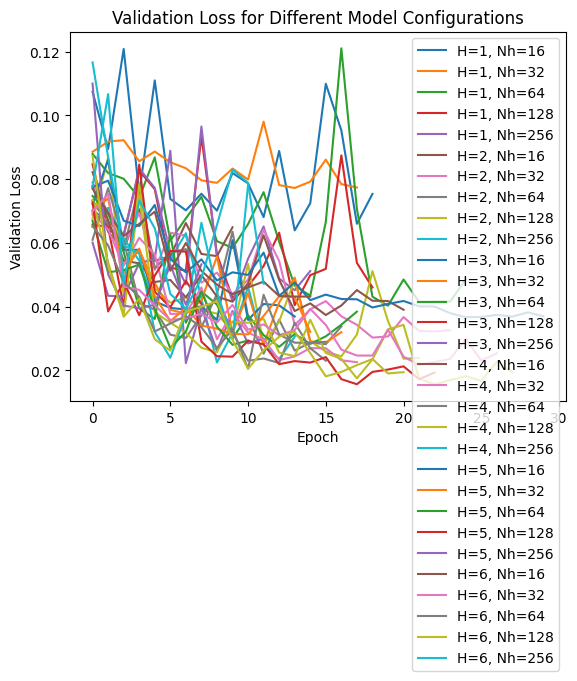

Model with H=1 and Nh=16:
MSE: 0.064139224588871
MAE: 0.06413921980895468
RMSE: 0.08496157679780499
R-squared: 0.976877239530554
MAPE: 10.668248805097894%
Model with H=1 and Nh=32:
MSE: 0.07775621861219406
MAE: 0.07775619389083394
RMSE: 0.11436407065510278
R-squared: 0.9581038840416086
MAPE: 11.2861668167188%
Model with H=1 and Nh=64:
MSE: 0.0409076064825058
MAE: 0.04090760959468003
RMSE: 0.059720257136671236
R-squared: 0.9885754818864984
MAPE: 5.84822299916512%
Model with H=1 and Nh=128:
MSE: 0.04081252962350845
MAE: 0.04081253211596939
RMSE: 0.057160462886015624
R-squared: 0.9895338723645885
MAPE: 5.876195570619439%
Model with H=1 and Nh=256:
MSE: 0.041919827461242676
MAE: 0.041919817051494675
RMSE: 0.05712575319150232
R-squared: 0.9895465792524647
MAPE: 5.599401276909245%
Model with H=2 and Nh=16:
MSE: 0.0549197755753994
MAE: 0.05491976764938602
RMSE: 0.07686795200979298
R-squared: 0.9810728522107292
MAPE: 8.336079134554385%
Model with H=2 and Nh=32:
MSE: 0.03067188337445259
MAE: 0.

In [37]:

# Iterate over different values of H and Nh
for H in H_values:
    for Nh in Nh_values:
        # Initialize a Sequential model
        model_5 = tf.keras.Sequential()

        # Add the first hidden layer with batch normalization
        model_5.add(tf.keras.layers.Dense(Nh, activation='relu', input_shape=(4,)))  
        model_5.add(tf.keras.layers.BatchNormalization())

        # Add subsequent hidden layers with batch normalization
        for _ in range(H - 1):
            model_5.add(tf.keras.layers.Dense(Nh, activation='relu'))
            model_5.add(tf.keras.layers.BatchNormalization())

        # Output layer (assuming it follows the hidden layers)
        model_5.add(tf.keras.layers.Dense(1, activation='softplus'))  

        # Compile the model
        model_5.compile(optimizer='adam', loss='mean_absolute_error')

        # Train the model and store the training history
    # Train the model with given hyperparameters
        history_5 = model_5.fit(X_train_5, y_train_5, epochs=100, batch_size=32, validation_data=(X_val_5, y_val_5), 
                        callbacks=[PrintEpochInfo(), lr_scheduler, early_stopping], verbose=0)
    
        histories_5[(H, Nh)] = history_5

        # Evaluate the model on the testing set
        predictions_5 = model_5.predict(X_test_5)

        # Evaluate the model on the testing set and calculate MSE
        mse_5 = model_5.evaluate(X_test_5, y_test_5)
        mses_5[(H, Nh)] = mse_5

        # Calculate Mean Absolute Error (MAE)
        mae_5 = mean_absolute_error(y_test_5, predictions_5)
        maes_5[(H, Nh)] = mae_5

        # Calculate Root Mean Squared Error (RMSE)
        rmse_5 = np.sqrt(mean_squared_error(y_test_5, predictions_5))
        rmses_5[(H, Nh)] = rmse_5

        # Calculate R-squared (R2) Score
        r2_5 = r2_score(y_test_5, predictions_5)
        r2_scores_5[(H, Nh)] = r2_5

        # Calculate Mean Absolute Percentage Error (MAPE)
        mape_5 = np.mean(np.abs((y_test_5 - predictions_5) / y_test_5)) * 100
        mapes_5[(H, Nh)] = mape_5

# Plot the validation loss for each configuration
for (H, Nh), history_5 in histories_5.items():
    plt.plot(history_5.history['val_loss'], label=f'H={H}, Nh={Nh}')

plt.title('Validation Loss for Different Model Configurations')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.legend()
plt.show()

# Print the MSE for each configuration
# Print the evaluation metrics for each configuration
for (H, Nh), mse_5 in mses_5.items():
    print(f'Model with H={H} and Nh={Nh}:')
    print(f'MSE: {mse_5}')
    print(f'MAE: {maes_5[(H, Nh)]}')
    print(f'RMSE: {rmses_5[(H, Nh)]}')
    print(f'R-squared: {r2_scores_5[(H, Nh)]}')
    print(f'MAPE: {mapes_5[(H, Nh)]}%')


In [39]:
# Rank combinations based on their MSE values
ranked_combinations_5 = sorted(mses_5.items(), key=lambda x: x[1])

# Print ranked combinations
for idx, ((H, Nh), mse_5) in enumerate(ranked_combinations_5, start=1):
    print(f"Rank {idx}: Combination H={H}, Nh={Nh} - MSE: {mse_5}")


Rank 1: Combination H=5, Nh=128 - MSE: 0.015396643429994583
Rank 2: Combination H=4, Nh=128 - MSE: 0.015585183165967464
Rank 3: Combination H=6, Nh=128 - MSE: 0.017896605655550957
Rank 4: Combination H=6, Nh=64 - MSE: 0.020771954208612442
Rank 5: Combination H=6, Nh=32 - MSE: 0.02188015542924404
Rank 6: Combination H=2, Nh=256 - MSE: 0.02221246063709259
Rank 7: Combination H=3, Nh=256 - MSE: 0.022380808368325233
Rank 8: Combination H=4, Nh=64 - MSE: 0.023133760318160057
Rank 9: Combination H=4, Nh=32 - MSE: 0.0232529453933239
Rank 10: Combination H=4, Nh=256 - MSE: 0.023860324174165726
Rank 11: Combination H=2, Nh=128 - MSE: 0.023978427052497864
Rank 12: Combination H=2, Nh=64 - MSE: 0.02498023211956024
Rank 13: Combination H=5, Nh=64 - MSE: 0.02702377736568451
Rank 14: Combination H=3, Nh=64 - MSE: 0.027645526453852654
Rank 15: Combination H=3, Nh=32 - MSE: 0.02850128710269928
Rank 16: Combination H=2, Nh=32 - MSE: 0.03067188337445259
Rank 17: Combination H=5, Nh=32 - MSE: 0.031828574

In [41]:
# Specify the combination you want to call
H = 5
Nh = 128

# Retrieve the model for the specified combination
selected_model_5 = histories_5[(H, Nh)].model
selected_model_5.save("model_5_128_Pllcu_2.h5")
# Use the trained model to make predictions on the testing set
prediction_5 = selected_model_5.predict(X_test_5)

# Evaluate the model on the testing set
mse_5_5 = selected_model_5.evaluate(X_test_5, y_test_5)
print("Mean Squared Error on Testing Set:", mse_5_5)

# Print the first few predictions
print("Predictions:")
print(prediction_5[:5])

# Print the corresponding true values
print("True Values:")
print(y_test_5[:5])

164/750 [=====>........................] - ETA: 0s

d:\Software\Python\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


750/750 [==============================] - 0s 641us/step - loss: 0.0154
Mean Squared Error on Testing Set: 0.015396643429994583
Predictions:
[[1.6219671 ]
 [0.49534276]
 [1.679996  ]
 [1.0782636 ]
 [0.6403374 ]]
True Values:
[[1.63623509]
 [0.46468755]
 [1.69007496]
 [1.10227304]
 [0.64733476]]


## P_D

In [42]:


# Fix random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Load your simulation data
# Replace "your_dataset.csv" with the path to your dataset
# df = pd.read_csv(r"D:\Krishna\ai-power-converter\dataset\simulation_results_63x13x13x13.csv")
df_6 = pd.read_csv(r"D:\Krishna\ai-power-converter\simulation_results_new_20_20_20_20.csv")

# Extract input features (L, C, fsw)
X_6 = df_6[['L', 'C', 'fsw', "t_dt"]].values

# Extract output (ripples)
y_6 = df_6[["P_D"]].values  # Adjust column names as per your dataset

# Define custom scaling ranges for each input feature
L_min, L_max = 30e-6, 2000e-6
C_min, C_max = 20e-6, 1000e-6
fsw_min, fsw_max = 20e3, 200e3
t_dt_min, t_dt_max = 0.178e-6, 1e-6

X_scaled_6 = custom_scaling(X_6)
print(X_scaled_6[90:])

# Split the dataset into training, validation, and testing sets
X_train_6, X_temp_6, y_train_6, y_temp_6 = train_test_split(X_scaled_6, y_6, test_size=0.3, random_state=42)
X_val_6, X_test_6, y_val_6, y_test_6 = train_test_split(X_temp_6, y_temp_6, test_size=0.5, random_state=42)

# Define a custom callback to print custom information at the end of each epoch
class PrintEpochInfo(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        print(f"Epoch {epoch+1}/{self.params['epochs']}, Loss: {logs['loss']}, Val Loss: {logs['val_loss']}")


# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=5, verbose=1, mode='auto', restore_best_weights=True)

# Define the learning rate scheduler
lr_scheduler = ReduceLROnPlateau(factor=0.5, patience=3, min_lr=1e-6)# Initialize a dictionary to store the training history for each configuration


histories_6 = {}

# Initialize dictionaries to store the evaluation metrics for each configuration
mses_6 = {}
maes_6 = {}
rmses_6 = {}
r2_scores_6 = {}
mapes_6 = {}

# Define a list of different values for H and Nh to try
H_values = [1, 2, 3, 4, 5, 6]  # Number of hidden layers
Nh_values = [16, 32, 64, 128, 256]  # Number of neurons per hidden layer

[[0.         0.01020408 0.21052222 0.52676399]
 [0.         0.01020408 0.21052222 0.57907543]
 [0.         0.01020408 0.21052222 0.63138686]
 ...
 [1.         0.18367347 1.         0.89416058]
 [1.         0.18367347 1.         0.94768856]
 [1.         0.18367347 1.         1.        ]]


Epoch 1/100, Loss: 0.03214908391237259, Val Loss: 0.004922715947031975
Epoch 2/100, Loss: 0.008073230274021626, Val Loss: 0.0040369415655732155
Epoch 3/100, Loss: 0.0076641240157186985, Val Loss: 0.0035918322391808033
Epoch 4/100, Loss: 0.0076166484504938126, Val Loss: 0.0035373871214687824
Epoch 5/100, Loss: 0.007659703493118286, Val Loss: 0.0039013135246932507
Epoch 6/100, Loss: 0.007614247500896454, Val Loss: 0.0034698094241321087
Epoch 7/100, Loss: 0.007552294060587883, Val Loss: 0.0034778700210154057
Epoch 8/100, Loss: 0.0075310468673706055, Val Loss: 0.004871927201747894
Restoring model weights from the end of the best epoch: 3.
Epoch 8: early stopping
750/750 [==============================] - 0s 477us/step - loss: 0.0036
Epoch 1/100, Loss: 0.023557111620903015, Val Loss: 0.005762232933193445
Epoch 2/100, Loss: 0.008103222586214542, Val Loss: 0.004437715746462345
Epoch 3/100, Loss: 0.007773005869239569, Val Loss: 0.0066151926293969154
Epoch 4/100, Loss: 0.007716188207268715, Val

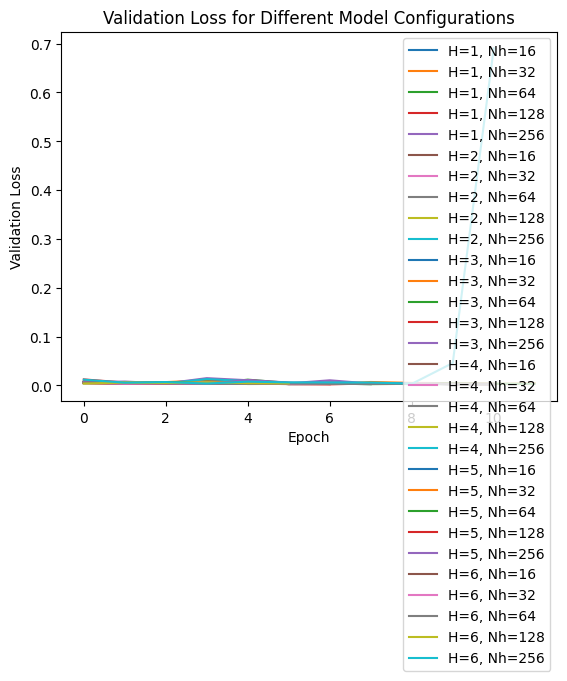

Model with H=1 and Nh=16:
MSE: 0.0035858317278325558
MAE: 0.0035858343048069427
RMSE: 0.004673447167117056
R-squared: 0.9859083094453156
MAPE: 5.369650880002293%
Model with H=1 and Nh=32:
MSE: 0.002993241650983691
MAE: 0.0029932432379913766
RMSE: 0.003921330635031587
R-squared: 0.9900790023327316
MAPE: 4.552494831522816%
Model with H=1 and Nh=64:
MSE: 0.0030050440691411495
MAE: 0.003005044010976919
RMSE: 0.003925622106335853
R-squared: 0.990057275537419
MAPE: 4.190933243395569%
Model with H=1 and Nh=128:
MSE: 0.002838274696841836
MAE: 0.002838274364516611
RMSE: 0.003761632061458698
R-squared: 0.9908706249330641
MAPE: 4.826369025270581%
Model with H=1 and Nh=256:
MSE: 0.0028349580243229866
MAE: 0.002834958100422741
RMSE: 0.0035206435048181963
R-squared: 0.9920029000216989
MAPE: 5.3656043818953245%
Model with H=2 and Nh=16:
MSE: 0.0033540776930749416
MAE: 0.003354077013769951
RMSE: 0.004670350698216717
R-squared: 0.9859269766195132
MAPE: 4.859403837657053%
Model with H=2 and Nh=32:
MSE: 

In [43]:

# Iterate over different values of H and Nh
for H in H_values:
    for Nh in Nh_values:
        # Initialize a Sequential model
        model_6 = tf.keras.Sequential()

        # Add the first hidden layer with batch normalization
        model_6.add(tf.keras.layers.Dense(Nh, activation='relu', input_shape=(4,)))  
        model_6.add(tf.keras.layers.BatchNormalization())

        # Add subsequent hidden layers with batch normalization
        for _ in range(H - 1):
            model_6.add(tf.keras.layers.Dense(Nh, activation='relu'))
            model_6.add(tf.keras.layers.BatchNormalization())

        # Output layer (assuming it follows the hidden layers)
        model_6.add(tf.keras.layers.Dense(1, activation='softplus'))  

        # Compile the model
        model_6.compile(optimizer='adam', loss='mean_absolute_error')

        # Train the model and store the training history
    # Train the model with given hyperparameters
        history_6 = model_6.fit(X_train_6, y_train_6, epochs=100, batch_size=32, validation_data=(X_val_6, y_val_6), 
                        callbacks=[PrintEpochInfo(), lr_scheduler, early_stopping], verbose=0)
    
        histories_6[(H, Nh)] = history_6

        # Evaluate the model on the testing set
        predictions_6 = model_6.predict(X_test_6)

        # Evaluate the model on the testing set and calculate MSE
        mse_6 = model_6.evaluate(X_test, y_test_6)
        mses_6[(H, Nh)] = mse_6

        # Calculate Mean Absolute Error (MAE)
        mae_6 = mean_absolute_error(y_test_6, predictions_6)
        maes_6[(H, Nh)] = mae_6

        # Calculate Root Mean Squared Error (RMSE)
        rmse_6 = np.sqrt(mean_squared_error(y_test_6, predictions_6))
        rmses_6[(H, Nh)] = rmse_6

        # Calculate R-squared (R2) Score
        r2_6 = r2_score(y_test_6, predictions_6)
        r2_scores_6[(H, Nh)] = r2_6

        # Calculate Mean Absolute Percentage Error (MAPE)
        mape_6 = np.mean(np.abs((y_test_6 - predictions_6) / y_test_6)) * 100
        mapes_6[(H, Nh)] = mape_6

# Plot the validation loss for each configuration
for (H, Nh), history_6 in histories_6.items():
    plt.plot(history_6.history['val_loss'], label=f'H={H}, Nh={Nh}')

plt.title('Validation Loss for Different Model Configurations')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.legend()
plt.show()

# Print the MSE for each configuration
# Print the evaluation metrics for each configuration
for (H, Nh), mse_6 in mses_6.items():
    print(f'Model with H={H} and Nh={Nh}:')
    print(f'MSE: {mse_6}')
    print(f'MAE: {maes_6[(H, Nh)]}')
    print(f'RMSE: {rmses_6[(H, Nh)]}')
    print(f'R-squared: {r2_scores_6[(H, Nh)]}')
    print(f'MAPE: {mapes_6[(H, Nh)]}%')


In [46]:
# Rank combinations based on their MSE values
ranked_combinations_6 = sorted(mses_6.items(), key=lambda x: x[1])

# Print ranked combinations
for idx, ((H, Nh), mse_6) in enumerate(ranked_combinations_6, start=1):
    print(f"Rank {idx}: Combination H={H}, Nh={Nh} - MSE: {mse_6}")


Rank 1: Combination H=1, Nh=256 - MSE: 0.0022864590864628553
Rank 2: Combination H=1, Nh=64 - MSE: 0.0024960271548479795
Rank 3: Combination H=6, Nh=32 - MSE: 0.0026410333812236786
Rank 4: Combination H=5, Nh=16 - MSE: 0.0027565425261855125
Rank 5: Combination H=2, Nh=128 - MSE: 0.0027624887879937887
Rank 6: Combination H=6, Nh=128 - MSE: 0.002770878141745925
Rank 7: Combination H=6, Nh=256 - MSE: 0.002908228663727641
Rank 8: Combination H=4, Nh=32 - MSE: 0.002908672671765089
Rank 9: Combination H=2, Nh=256 - MSE: 0.002937649143859744
Rank 10: Combination H=4, Nh=64 - MSE: 0.002944887848570943
Rank 11: Combination H=5, Nh=64 - MSE: 0.0029506010469049215
Rank 12: Combination H=2, Nh=32 - MSE: 0.003049223916605115
Rank 13: Combination H=4, Nh=16 - MSE: 0.0031143855303525925
Rank 14: Combination H=3, Nh=64 - MSE: 0.0031179110519587994
Rank 15: Combination H=2, Nh=64 - MSE: 0.00315296882763505
Rank 16: Combination H=6, Nh=64 - MSE: 0.0032342507038265467
Rank 17: Combination H=4, Nh=256 - M

In [45]:
# Specify the combination you want to call
H = 1
Nh = 256

# Retrieve the model for the specified combination
selected_model_6 = histories_6[(H, Nh)].model
selected_model_6.save("model_1_256_pd_2.h5")
# Use the trained model to make predictions on the testing set
prediction_6 = selected_model_6.predict(X_test_6)

# Evaluate the model on the testing set
mse_6_6 = selected_model_6.evaluate(X_test_6, y_test_6)
print("Mean Squared Error on Testing Set:", mse_6_6)

# Print the first few predictions
print("Predictions:")
print(prediction_6[:5])

# Print the corresponding true values
print("True Values:")
print(y_test_6[:5])

307/750 [===========>..................] - ETA: 0s

d:\Software\Python\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


750/750 [==============================] - 0s 518us/step - loss: 0.0028
Mean Squared Error on Testing Set: 0.0028349580243229866
Predictions:
[[0.0681546 ]
 [0.13470736]
 [0.06336228]
 [0.05368889]
 [0.11116327]]
True Values:
[[0.06506221]
 [0.13715643]
 [0.05960087]
 [0.05289084]
 [0.10150244]]
